In [1]:
import os
from tifffile import imread
from skimage.measure import regionprops
from scipy.ndimage import find_objects
import numpy as np
import nd2
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm

import seaborn as sns
import plotly.express as px

In [2]:
root = "/mnt/z/Dasha/2. FAST-AB biosensors/Microscope/Inverted bladder model/NCCRBM_114/To analyze for the figure"
model = "2025_12_22_Dasha_ibm-01"

In [3]:
def calc_ratios(values):
    means = np.concat((
        np.mean(values, axis=0)[np.newaxis, :],
        np.percentile(values, q=[50, 75, 90, 95], axis=0),
    ), axis=0)
    return np.concat((means[:, 1] / means[:, 0], means[:, 0], means[:, 1]))

value_vars = ["mean", "median", "75 %", "90 %", "95 %"]
def calc_df(t, m, file):
    filename = f"{file}_t{t}_m{m}_mScarlet.tiff"
    
    lbl = imread(os.path.join(root, "nfmp_prob0.6", model, filename))
    
    nd2_file = nd2.ND2File(os.path.join(root, file+".nd2"))
    img = nd2_file.to_dask()[t, m, :, 1:].compute().transpose(0, 2, 3, 1)
    lbl = lbl[:img.shape[0]]
    nd2_file.close()

    bg = np.median(img[lbl==0], axis=0)
    print(bg)
    img = img - bg
    
    objects = find_objects(lbl)

    values = []
    lbl_id = []
    for i, sl in enumerate(objects, 1):
        if sl is None: continue
        mask = lbl[sl] == i
        values.append(calc_ratios(img[sl][mask]))
        lbl_id.append(i)
    values_np = np.stack(values, axis=0)

    dfs = []
    for j, ty in enumerate(["ratio", "mScarlet", "gfp"]):
        values = {t: values_np[:, i+j*len(value_vars)] for i, t in enumerate(value_vars)}
        values["t"] = t
        values["m"] = m
        values["file"] = file
        values["insert"] = file.split("_")[-1]
        values["lbl_id"] = lbl_id
        values["type"] = ty
        dfs.append(pd.DataFrame(values))

    return pd.concat(dfs, ignore_index=True)

def get_props(t, m, file):
    filename = f"{file}_t{t}_m{m}_mScarlet.tiff"
    
    lbl = imread(os.path.join(root, "nfmp_prob0.6", model, filename))

    objects = find_objects(lbl)
    for i, sl in enumerate(objects, 1):
        if sl is None: continue
        mask = lbl[sl] == i
        if mask.sum() < 20:
            imprint = lbl[sl]
            imprint[mask] = 0
            lbl[sl] = imprint
    
    props = regionprops(lbl)
    values = {
        v: [p[v] for p in props]
        for v in [
            "label",
            #"eccentricity",
            "axis_major_length",
            "axis_minor_length",
            "area",
            #"solidity",
            #"perimeter",
        ]
    }
    values["t"] = t
    values["m"] = m
    values["file"] = file
    return pd.DataFrame(values)

In [4]:
dfs = []
props_dfs = []
for t in range(2):
    for m in trange(1):
        for i in tqdm([1]):#, 3, 4], leave=False):
            dfs.append(
                calc_df(t, m, f"Fig.4_h_TrimFABS_ANOX_mScarlet_insert{i}")
            )
            props_dfs.append(
                get_props(t, m, f"Fig.4_h_TrimFABS_ANOX_mScarlet_insert{i}")
            )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[175. 238.]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[177. 235.]


In [5]:
props_df = pd.concat(props_dfs, ignore_index=True)
props_df["aspect ratio"] = props_df["axis_major_length"] / props_df["axis_minor_length"]

In [6]:
df = pd.concat(dfs, ignore_index=True)
df = df.melt(id_vars=["t", "m", "file", "lbl_id", "type"], value_vars=value_vars, var_name="quantification")
df = df.pivot_table(columns="type", values="value", index=["t", "m", "file", "lbl_id", "quantification"]).reset_index()
df = df[df["ratio"]>0]
df = df[df["ratio"]<10]

df = df.merge(props_df, left_on=["lbl_id", "t", "m", "file"], right_on=["label", "t", "m", "file"])

In [7]:
df

,t,m,file,lbl_id,quantification,gfp,mScarlet,ratio,label,axis_major_length,axis_minor_length,area,aspect ratio
0,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,2,75 %,19.000000,133.000000,0.142857,2,14.618579,8.732572,640.0,1.674029
1,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,2,90 %,41.000000,169.000000,0.242604,2,14.618579,8.732572,640.0,1.674029
2,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,2,95 %,56.000000,183.200000,0.305677,2,14.618579,8.732572,640.0,1.674029
3,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,4,75 %,35.000000,160.000000,0.218750,4,31.445946,6.693741,867.0,4.697814
4,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,4,90 %,55.400000,189.000000,0.293122,4,31.445946,6.693741,867.0,4.697814
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9507,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,75 %,133.000000,103.500000,1.285024,997,6.738663,4.999341,90.0,1.347910
9508,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,90 %,147.000000,121.500000,1.209877,997,6.738663,4.999341,90.0,1.347910
9509,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,95 %,159.550000,133.650000,1.193790,997,6.738663,4.999341,90.0,1.347910
9510,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,mean,103.411111,88.811111,1.164394,997,6.738663,4.999341,90.0,1.347910


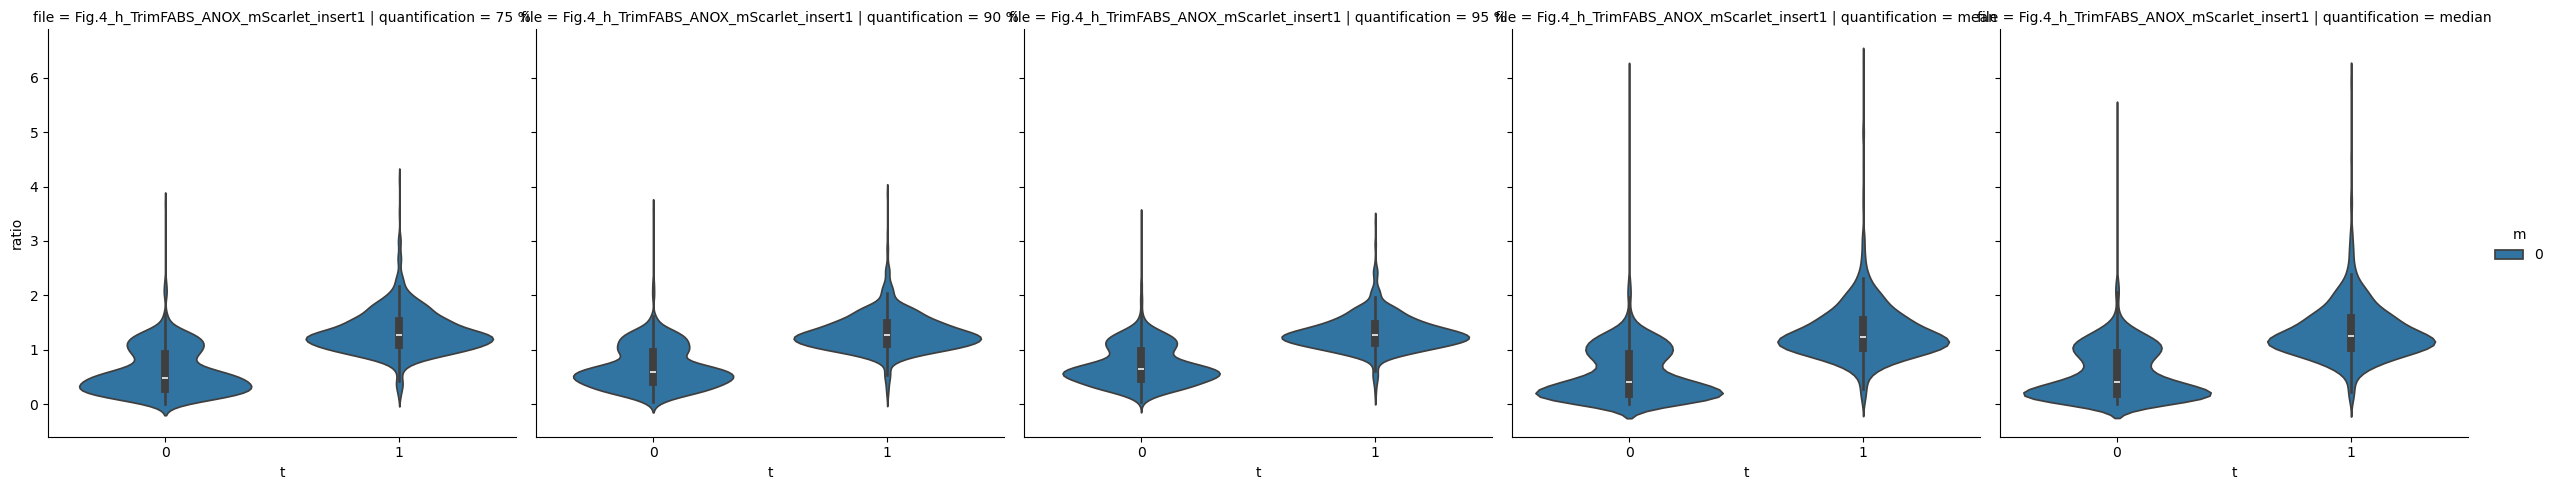

In [8]:
sns.catplot(
    data=df,
    x="t",
    y="ratio",
    hue="m",
    col="quantification",
    row="file",
    kind="violin",
)

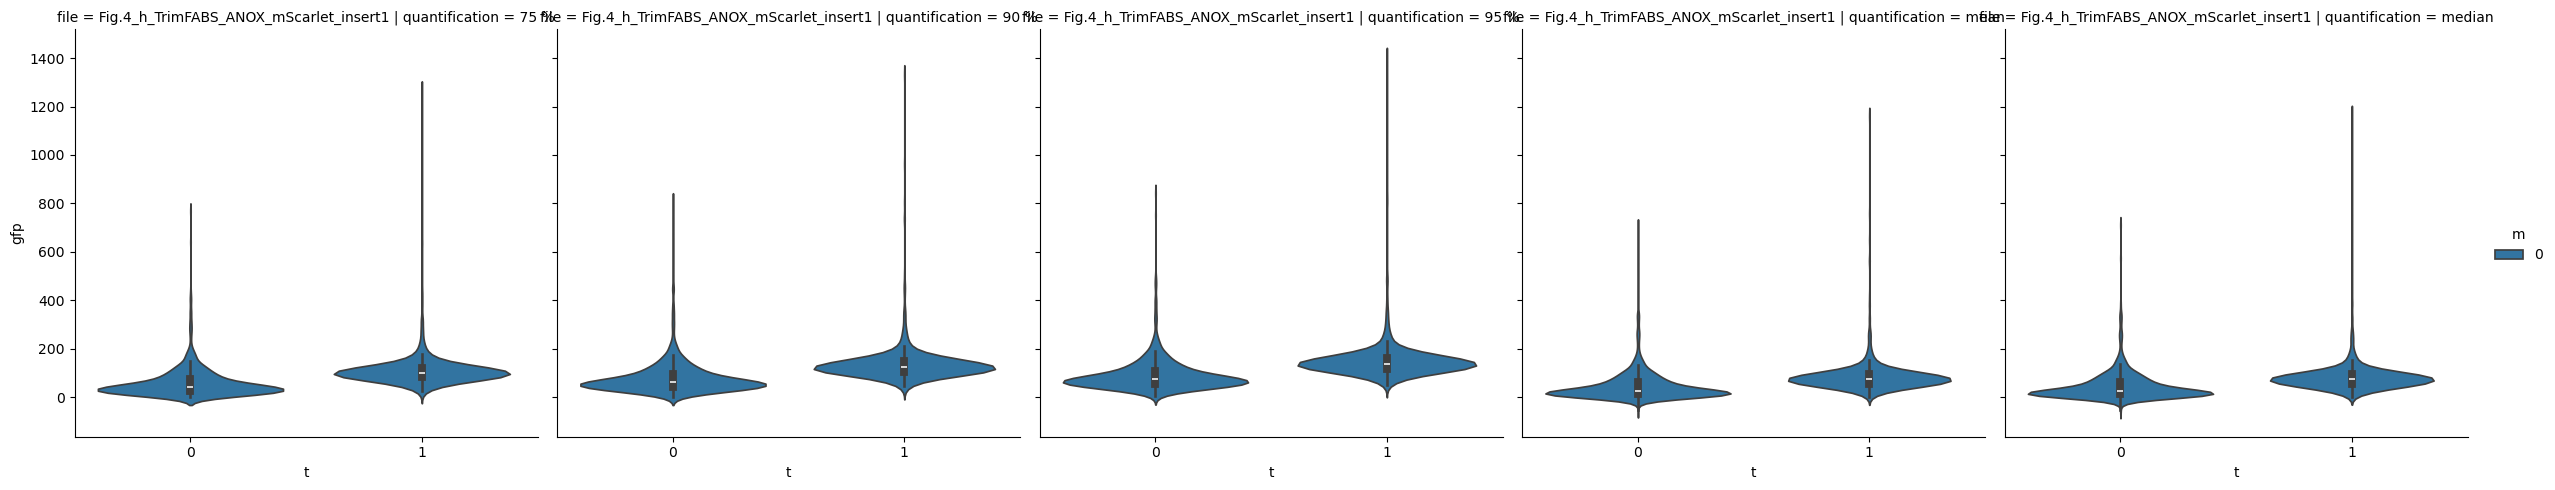

In [9]:
sns.catplot(
    data=df,
    x="t",
    y="gfp",
    hue="m",
    col="quantification",
    row="file",
    kind="violin",
)

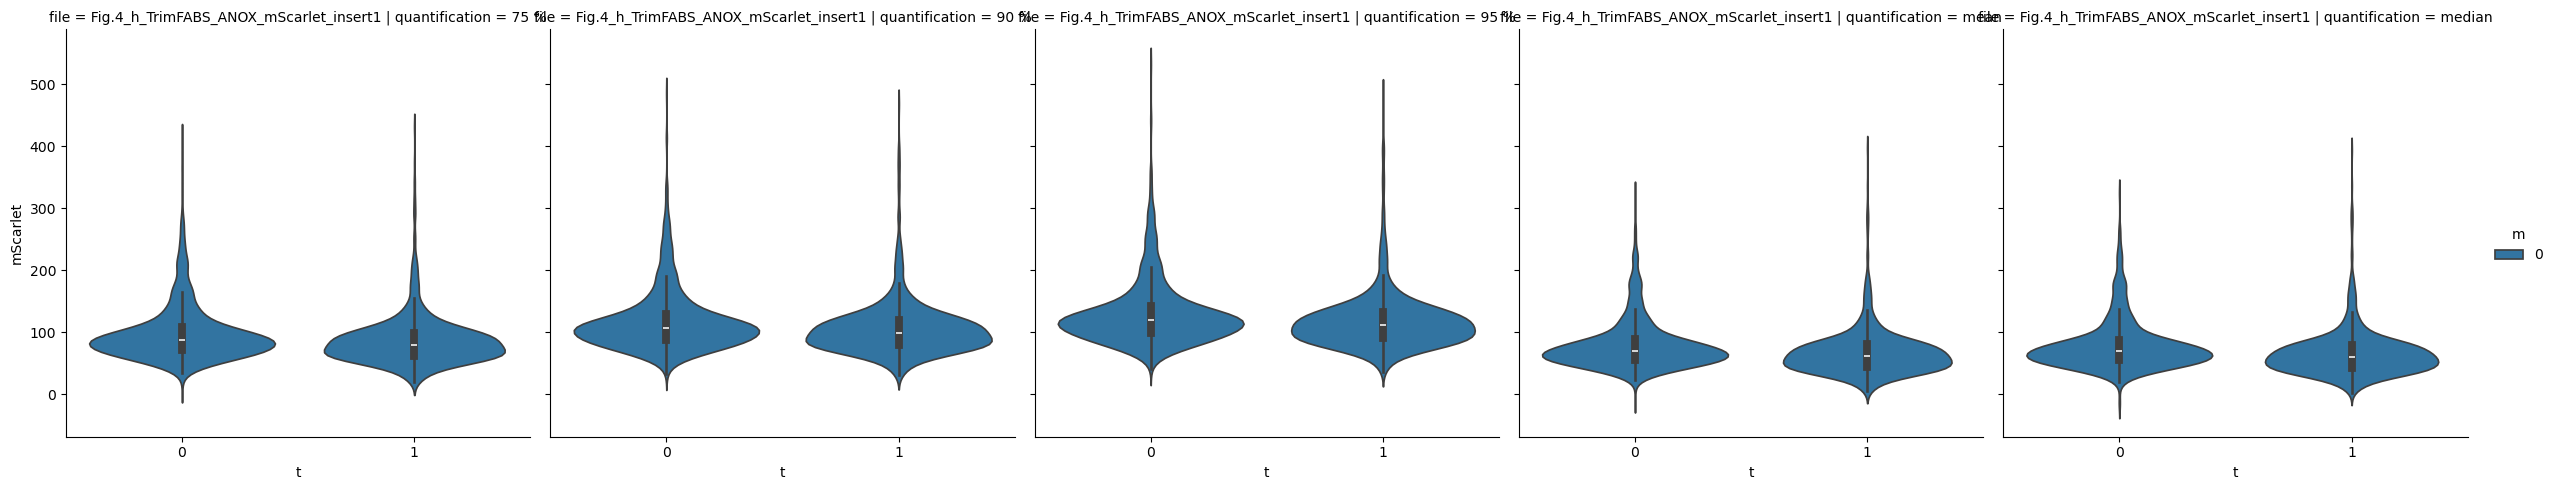

In [10]:
sns.catplot(
    data=df,
    x="t",
    y="mScarlet",
    hue="m",
    col="quantification",
    row="file",
    kind="violin",
)

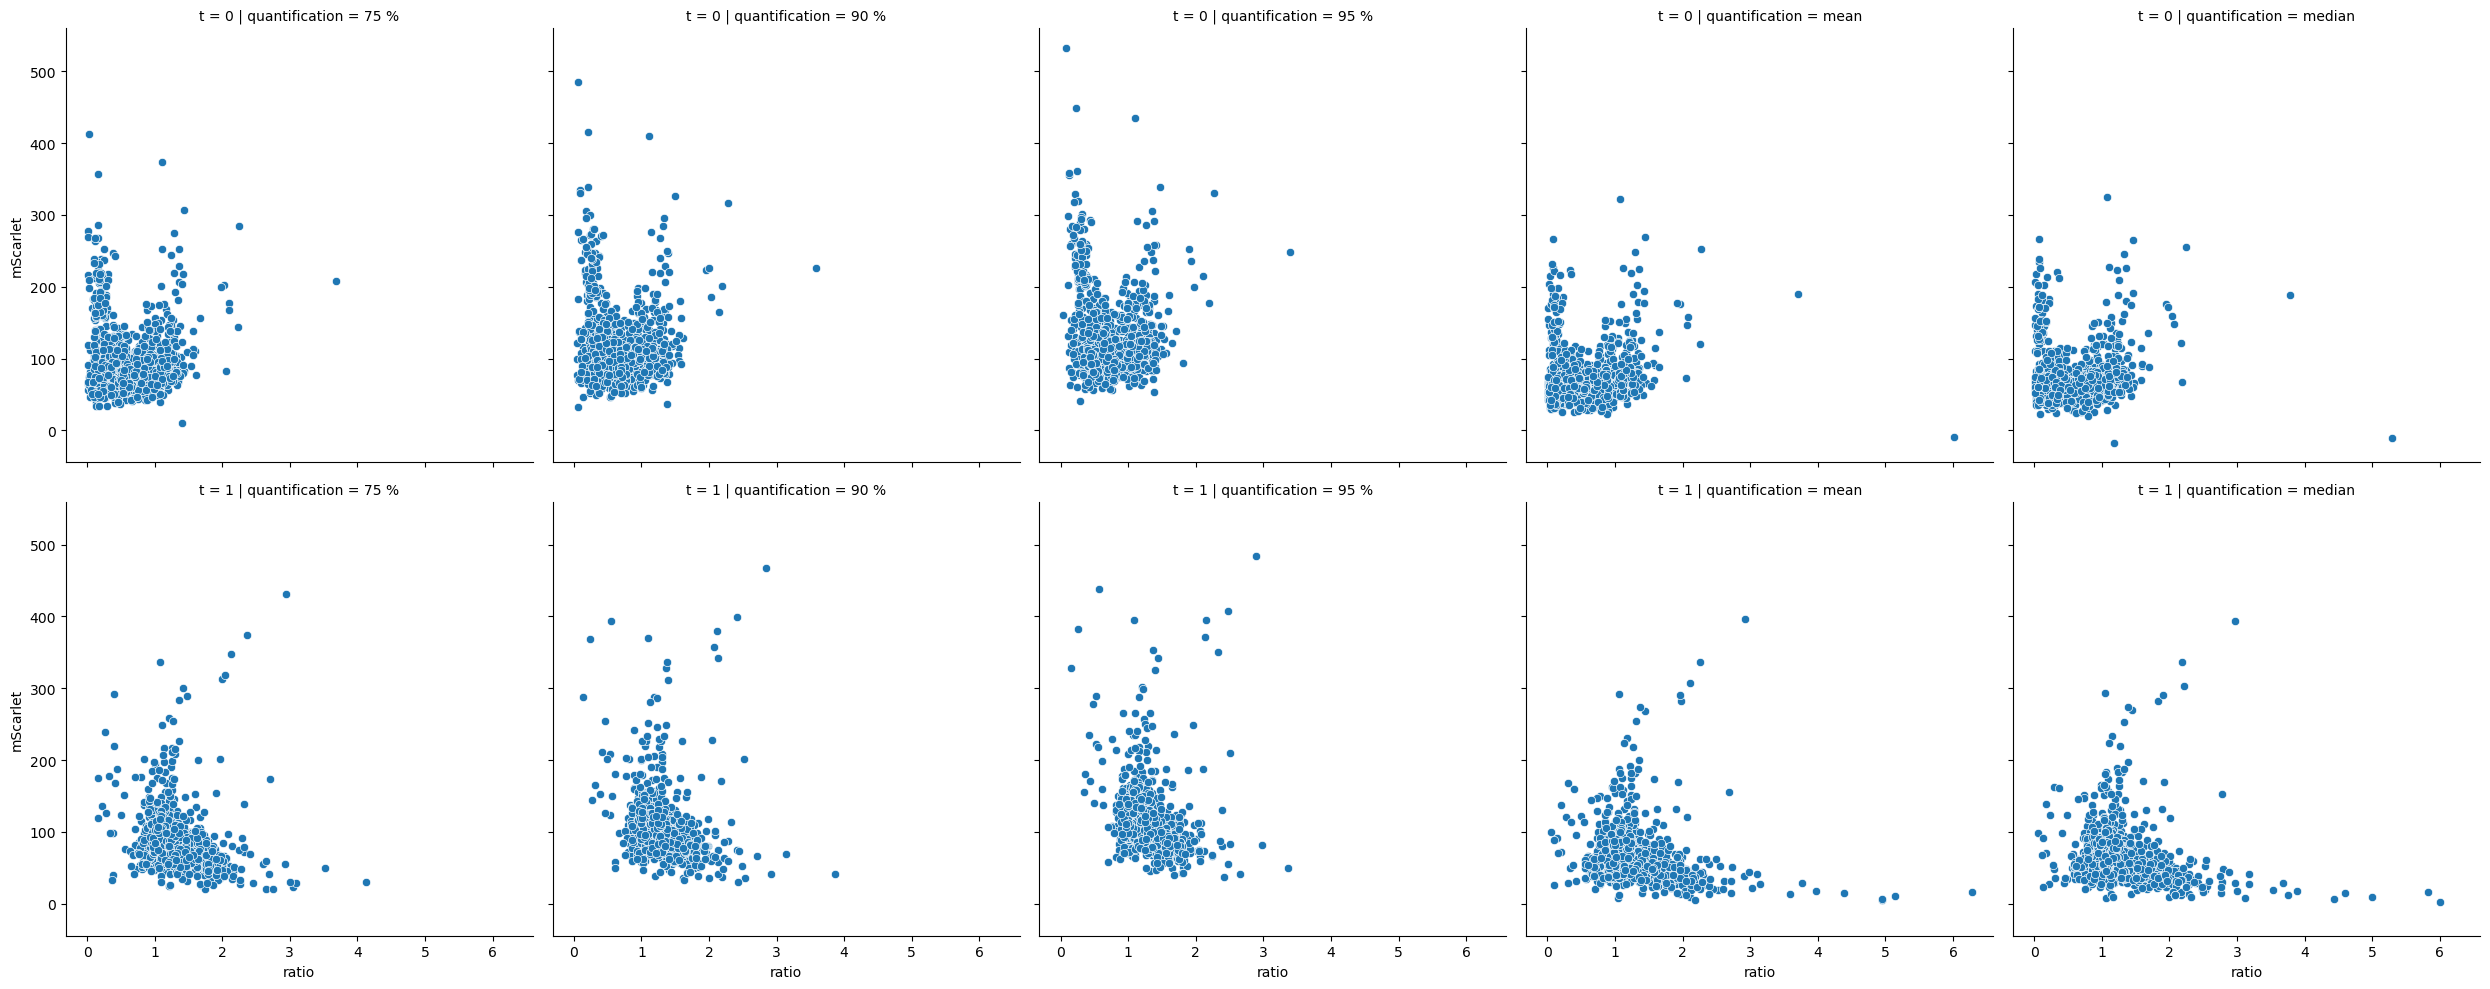

In [11]:
sns.relplot(
    data=df,
    x="ratio",
    y="mScarlet",
    col="quantification",
    row="t",
)

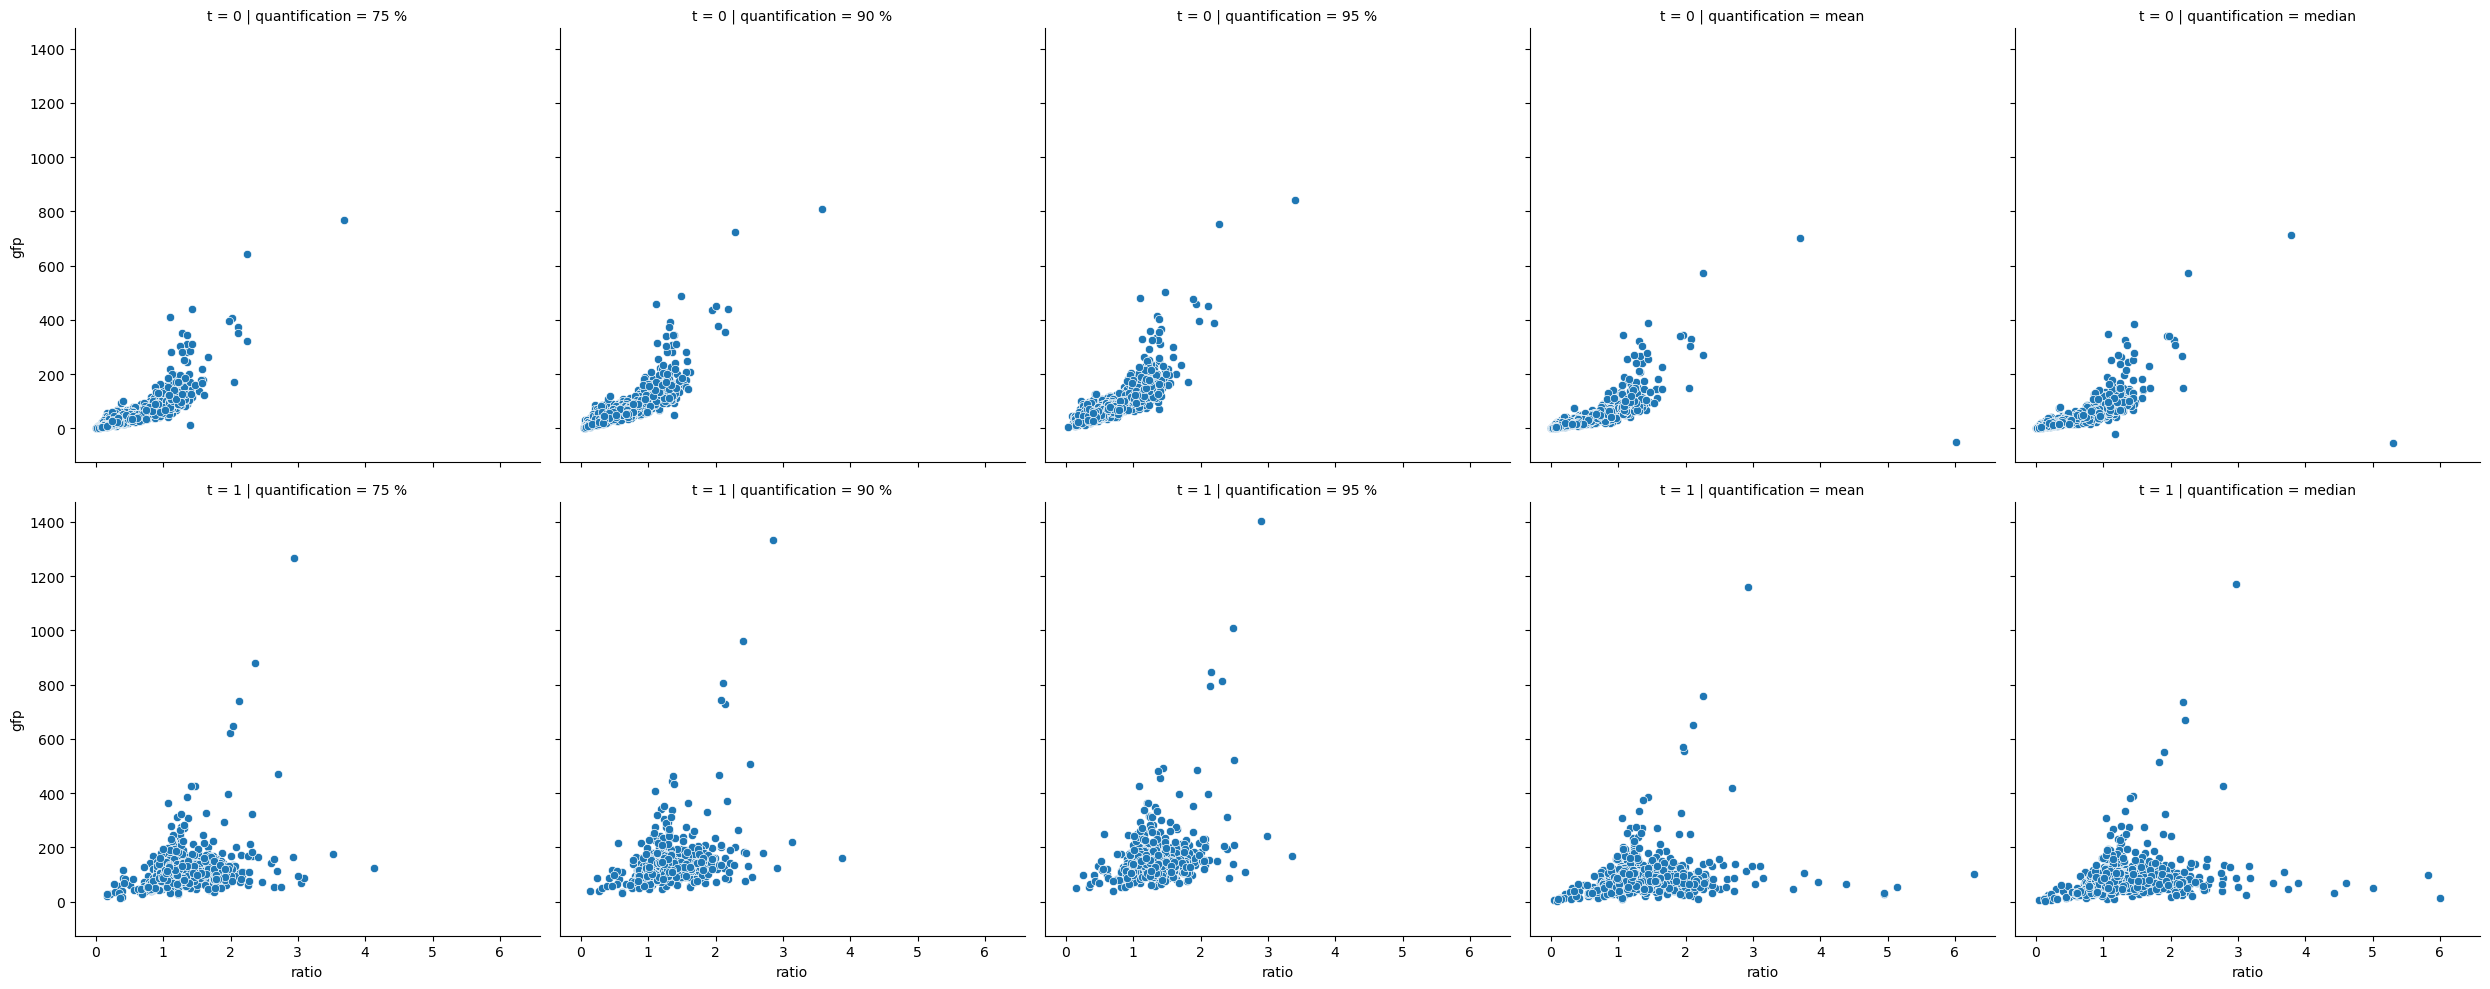

In [12]:
sns.relplot(
    data=df,
    x="ratio",
    y="gfp",
    col="quantification",
    row="t",
)

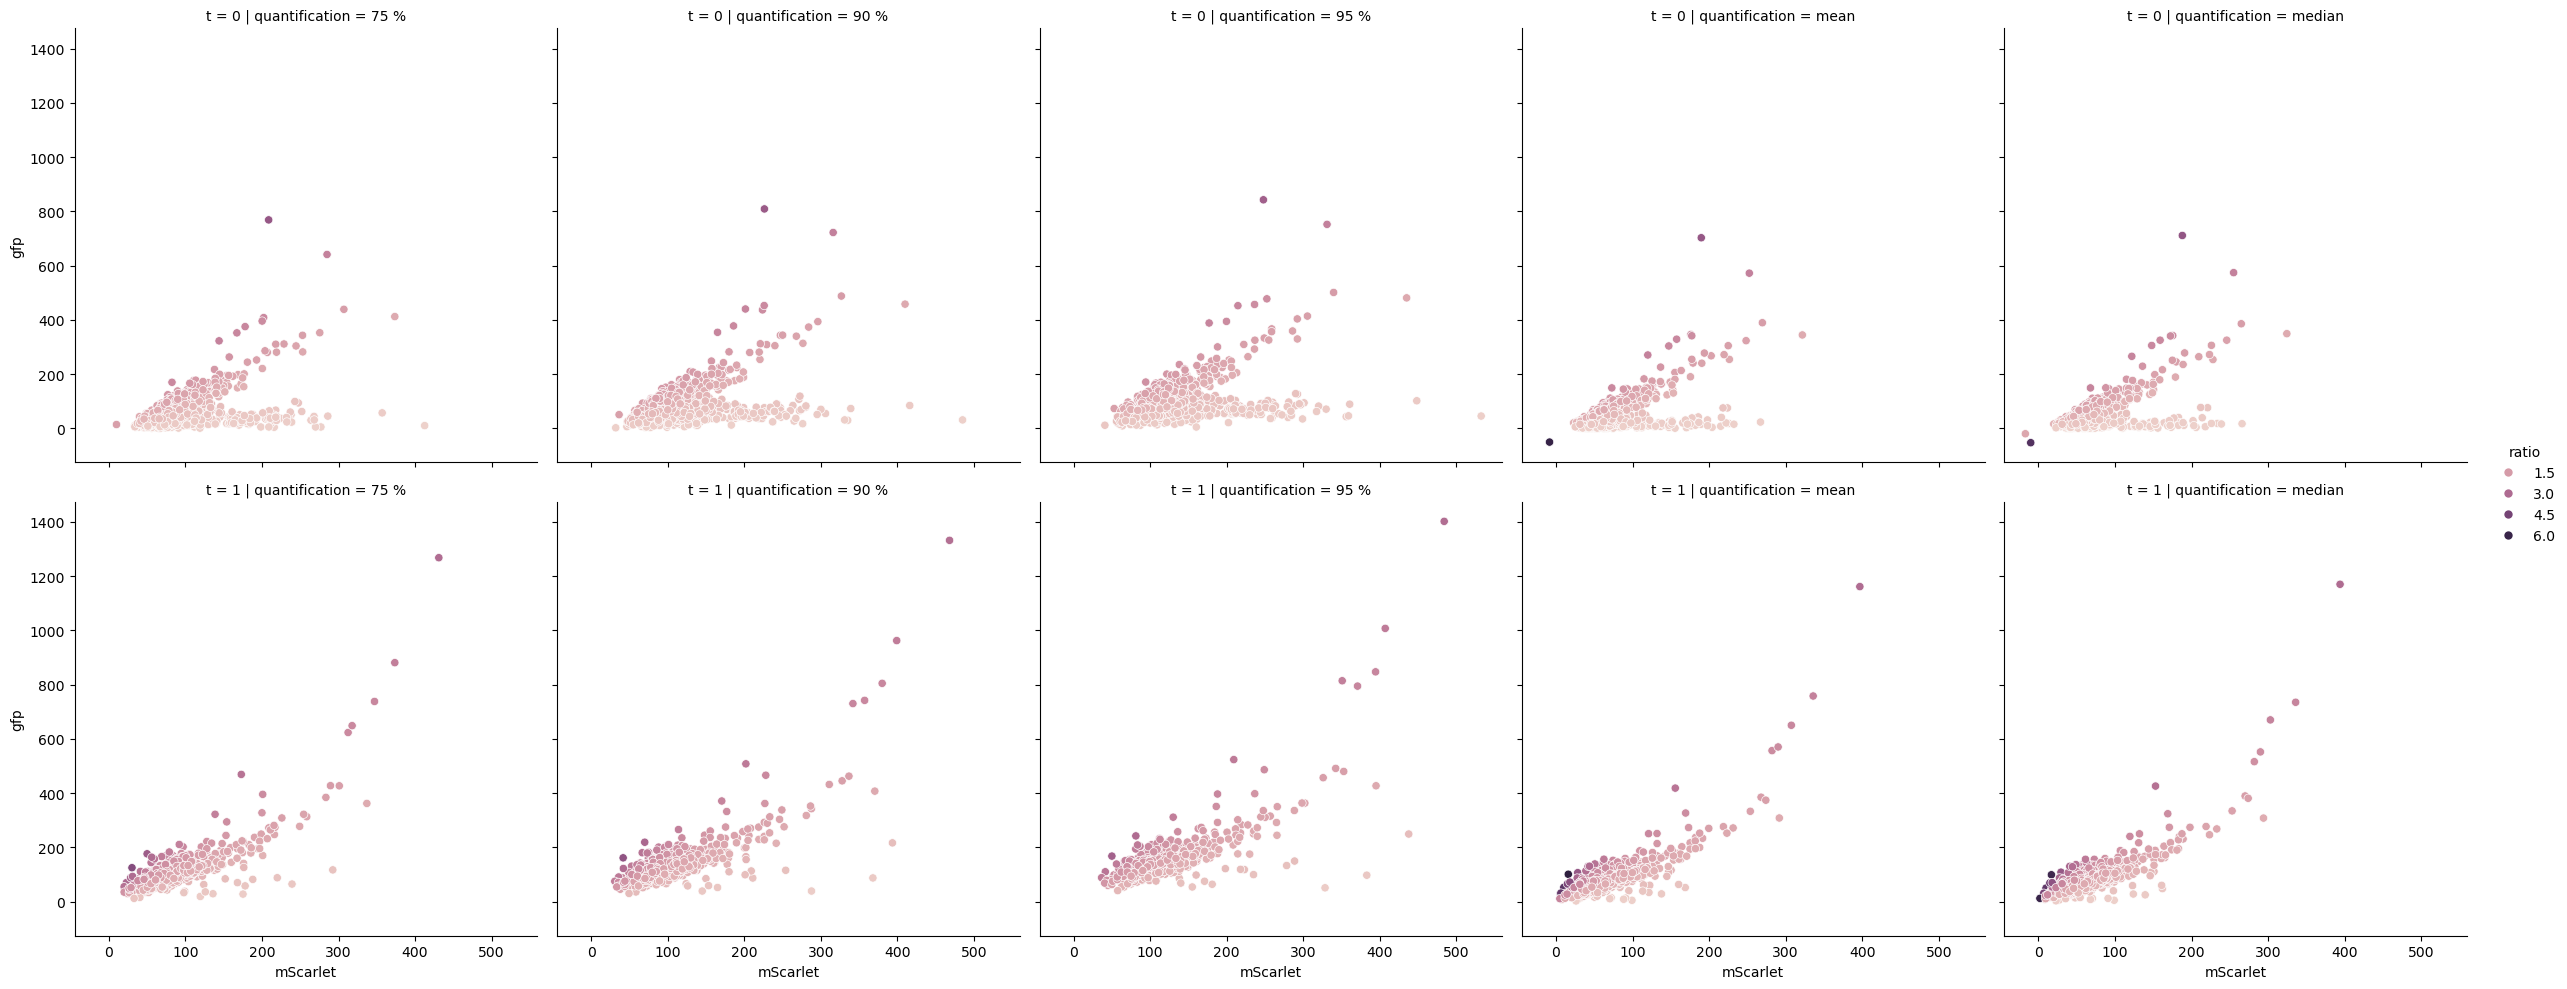

In [13]:
sns.relplot(
    data=df,
    x="mScarlet",
    y="gfp",
    col="quantification",
    row="t",
    hue="ratio",
)

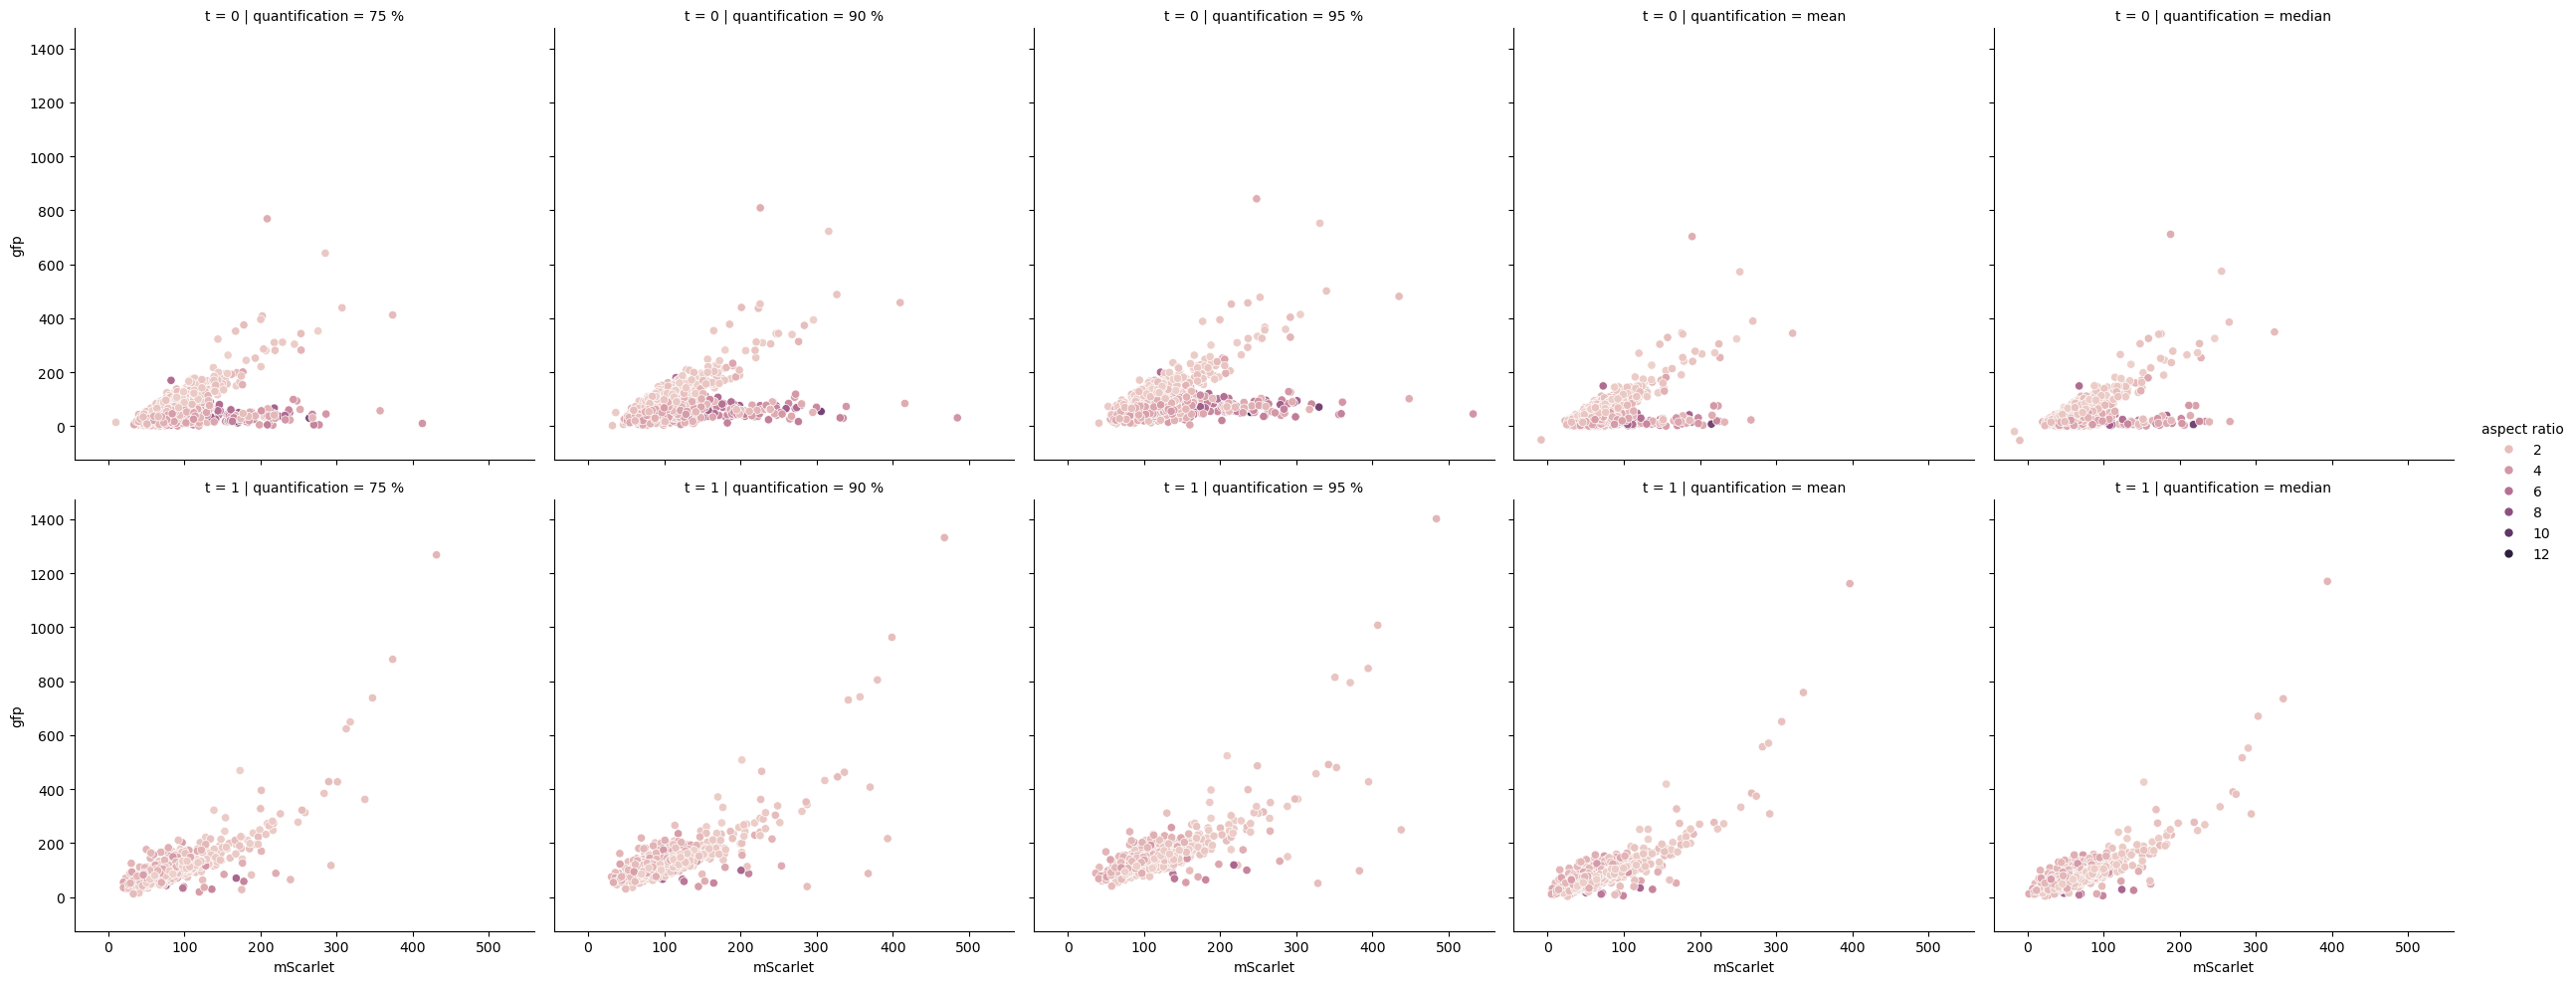

In [14]:
sns.relplot(
    data=df,
    x="mScarlet",
    y="gfp",
    col="quantification",
    row="t",
    hue="aspect ratio",
)

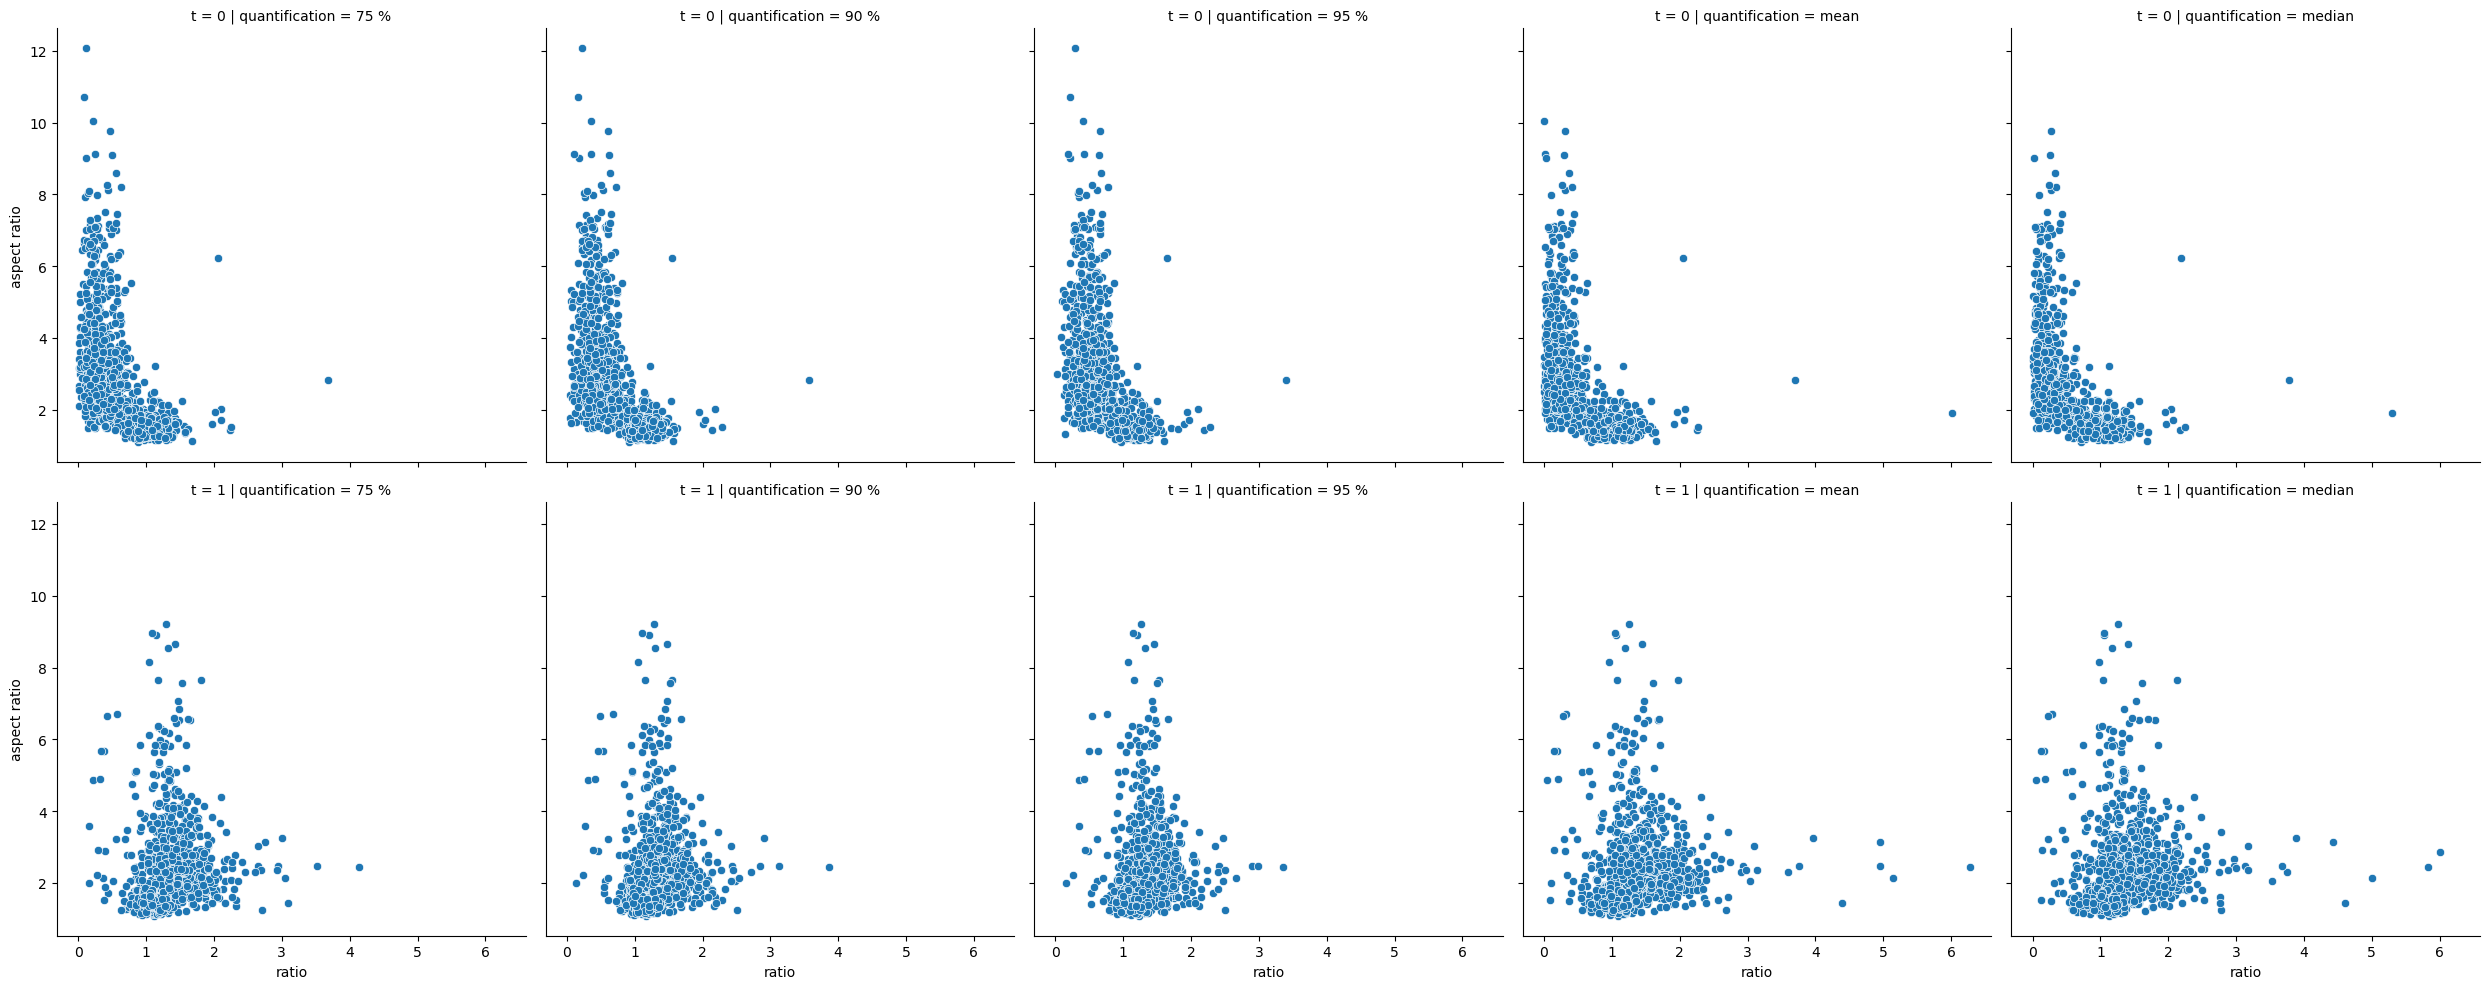

In [15]:
sns.relplot(
    data=df,
    x="ratio",
    y="aspect ratio",
    col="quantification",
    row="t",
    #hue="aspect ratio",
)

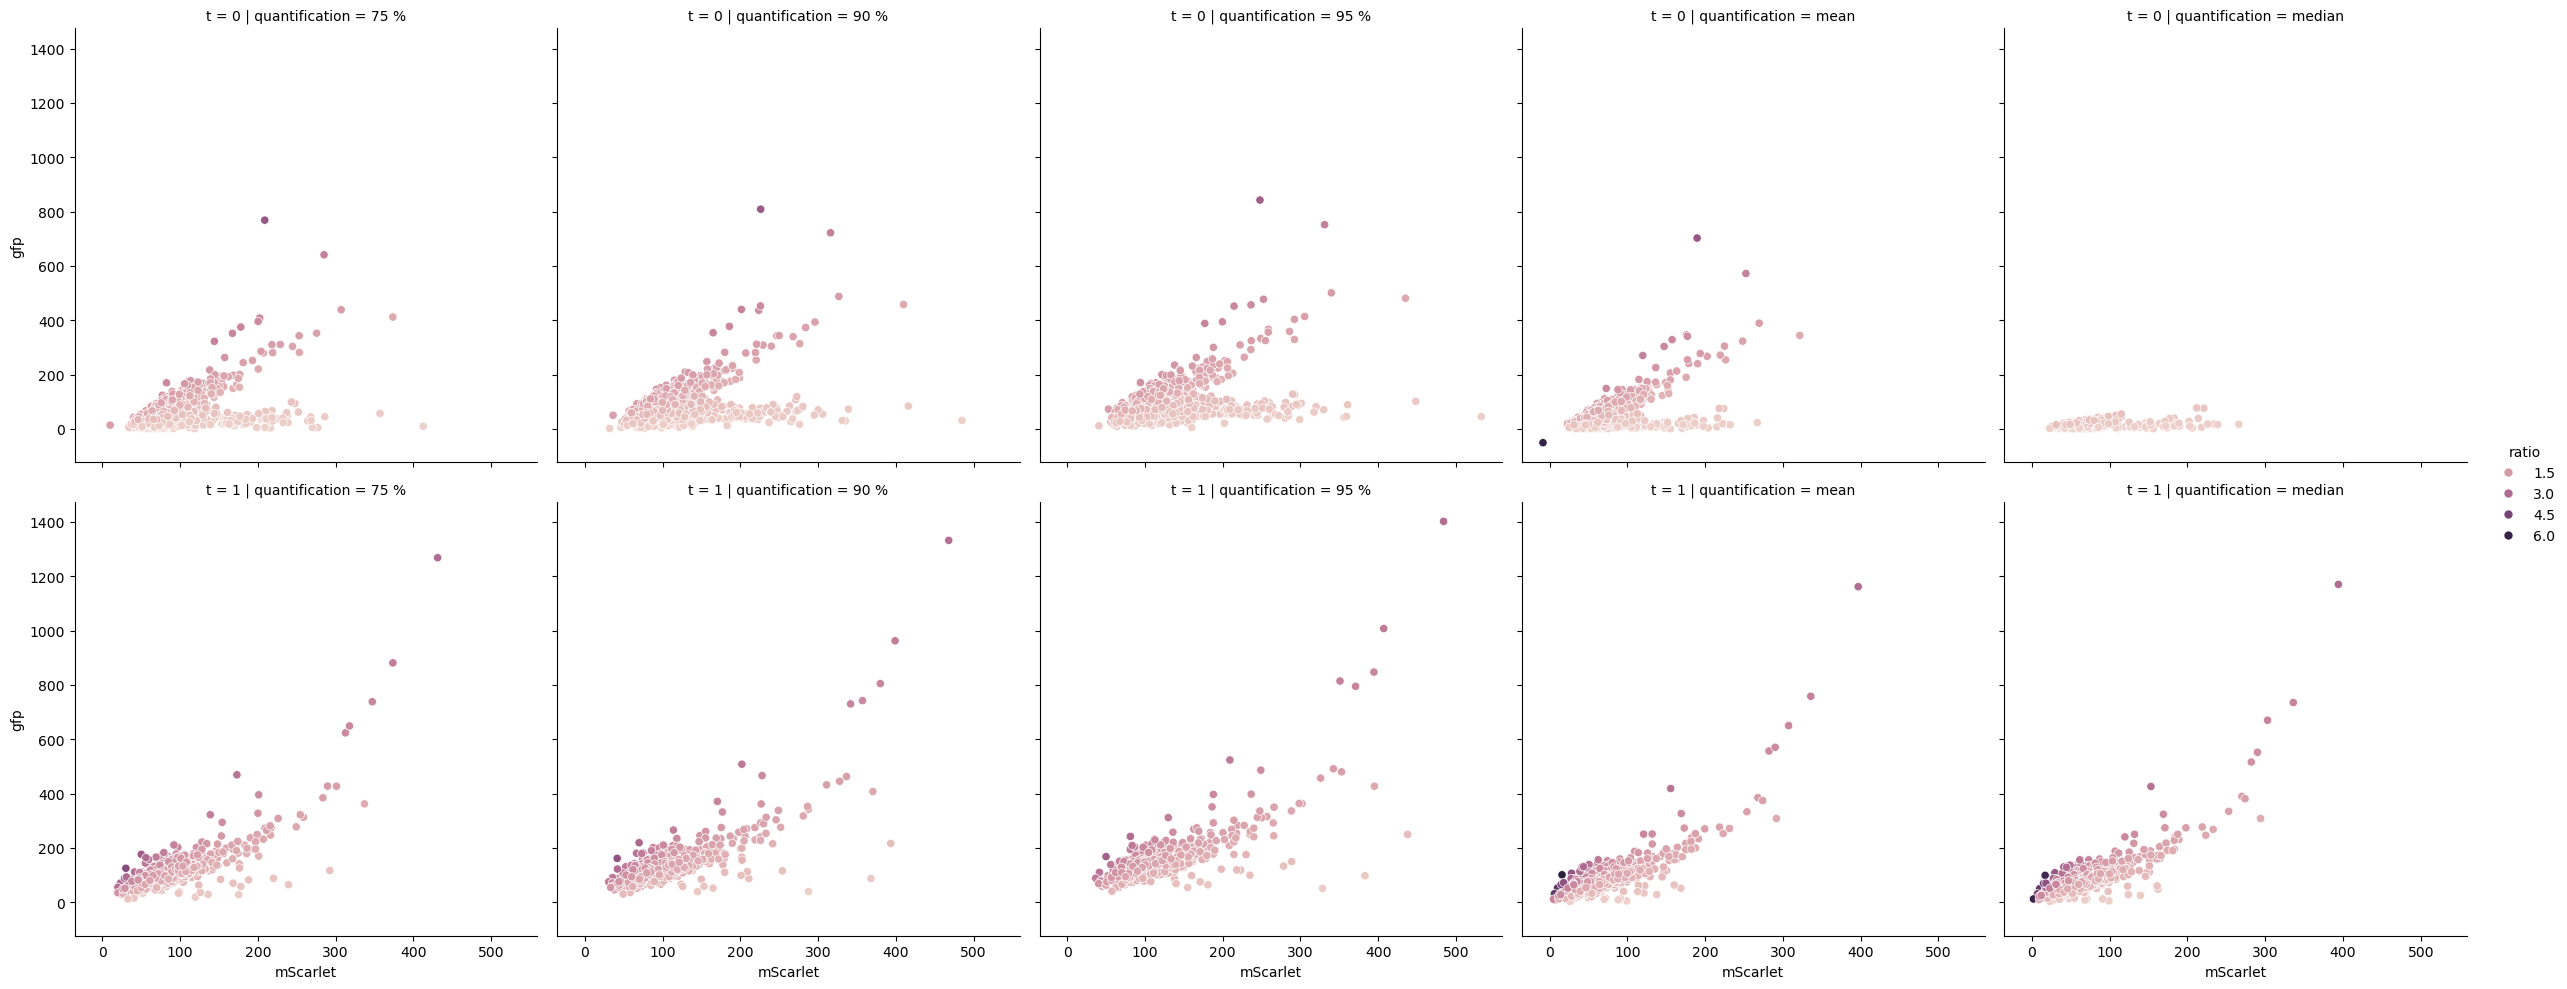

In [16]:
inds = (df["quantification"] == "median") & (df["t"] == 0) & (df["ratio"] > 0.5)

sns.relplot(
    data=df[~inds],
    x="mScarlet",
    y="gfp",
    col="quantification",
    row="t",
    hue="ratio",
)

In [17]:
px.scatter(
    df[(df["quantification"] == "median") & (df["t"] == 0)],
    x="mScarlet",
    y="gfp",
    color="ratio",
    hover_data=["lbl_id", "gfp", "mScarlet", "ratio"],
)

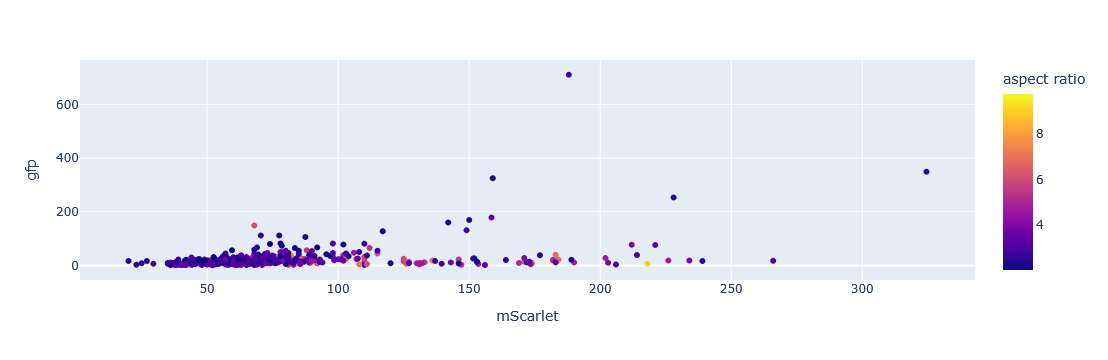

In [18]:
px.scatter(
    df[(df["quantification"] == "median") & (df["t"] == 0) & (df["aspect ratio"] > 2)],
    x="mScarlet",
    y="gfp",
    color="aspect ratio",
)

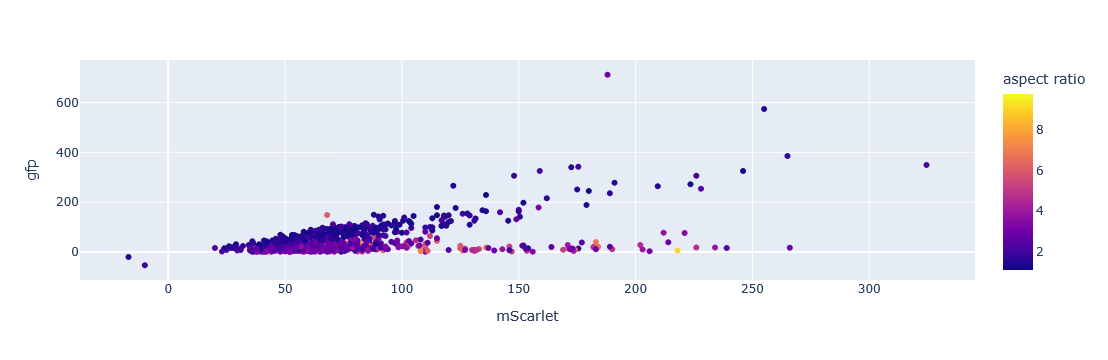

In [19]:
px.scatter(
    df[(df["quantification"] == "median") & (df["t"] == 0)],
    x="mScarlet",
    y="gfp",
    color="aspect ratio",
)

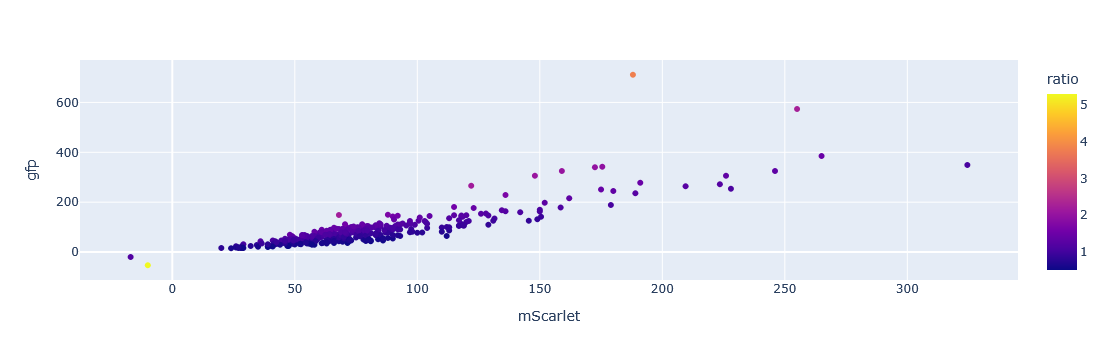

In [20]:
tmp = df[(df["quantification"] == "median") & (df["t"] == 0)]
tmp = tmp[(tmp["ratio"] > 0.5)]

px.scatter(
    tmp,
    x="mScarlet",
    y="gfp",
    color="ratio",
    hover_data=["lbl_id", "gfp", "mScarlet", "ratio"],
)

In [21]:
df

,t,m,file,lbl_id,quantification,gfp,mScarlet,ratio,label,axis_major_length,axis_minor_length,area,aspect ratio
0,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,2,75 %,19.000000,133.000000,0.142857,2,14.618579,8.732572,640.0,1.674029
1,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,2,90 %,41.000000,169.000000,0.242604,2,14.618579,8.732572,640.0,1.674029
2,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,2,95 %,56.000000,183.200000,0.305677,2,14.618579,8.732572,640.0,1.674029
3,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,4,75 %,35.000000,160.000000,0.218750,4,31.445946,6.693741,867.0,4.697814
4,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,4,90 %,55.400000,189.000000,0.293122,4,31.445946,6.693741,867.0,4.697814
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9507,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,75 %,133.000000,103.500000,1.285024,997,6.738663,4.999341,90.0,1.347910
9508,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,90 %,147.000000,121.500000,1.209877,997,6.738663,4.999341,90.0,1.347910
9509,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,95 %,159.550000,133.650000,1.193790,997,6.738663,4.999341,90.0,1.347910
9510,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,mean,103.411111,88.811111,1.164394,997,6.738663,4.999341,90.0,1.347910


In [22]:
df

,t,m,file,lbl_id,quantification,gfp,mScarlet,ratio,label,axis_major_length,axis_minor_length,area,aspect ratio
0,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,2,75 %,19.000000,133.000000,0.142857,2,14.618579,8.732572,640.0,1.674029
1,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,2,90 %,41.000000,169.000000,0.242604,2,14.618579,8.732572,640.0,1.674029
2,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,2,95 %,56.000000,183.200000,0.305677,2,14.618579,8.732572,640.0,1.674029
3,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,4,75 %,35.000000,160.000000,0.218750,4,31.445946,6.693741,867.0,4.697814
4,0,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,4,90 %,55.400000,189.000000,0.293122,4,31.445946,6.693741,867.0,4.697814
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9507,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,75 %,133.000000,103.500000,1.285024,997,6.738663,4.999341,90.0,1.347910
9508,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,90 %,147.000000,121.500000,1.209877,997,6.738663,4.999341,90.0,1.347910
9509,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,95 %,159.550000,133.650000,1.193790,997,6.738663,4.999341,90.0,1.347910
9510,1,0,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,997,mean,103.411111,88.811111,1.164394,997,6.738663,4.999341,90.0,1.347910


In [23]:
df.pivot_table(columns="type", values="ratio", index=["t", "m", "file", "lbl_id", "quantification"]).reset_index()

KeyError: 'type'

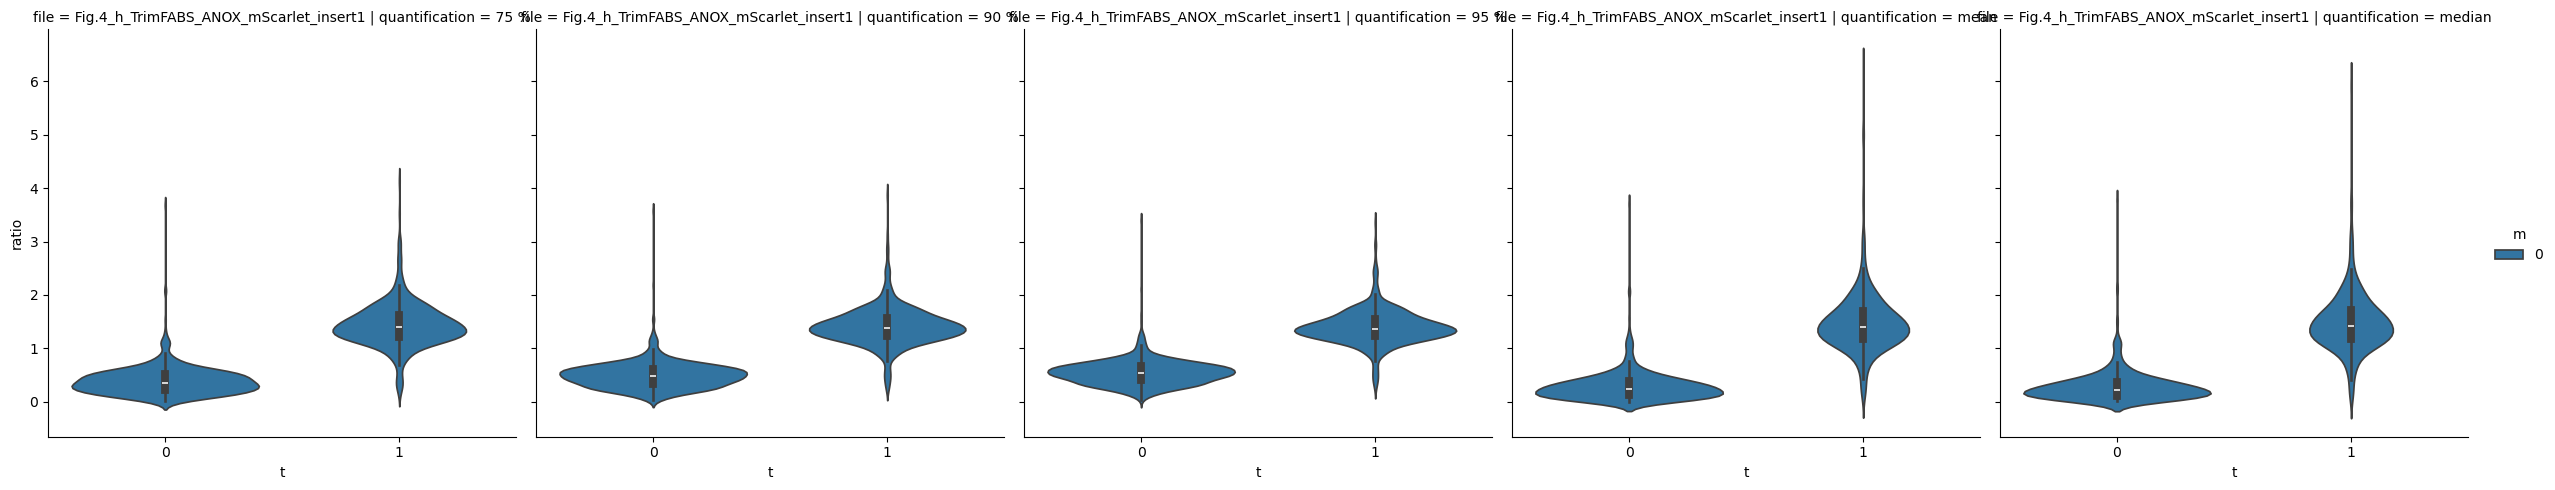

In [24]:
sns.catplot(
    data=df[df["aspect ratio"] > 2],
    x="t",
    y="ratio",
    hue="m",
    col="quantification",
    row="file",
    kind="violin",
)

plt.savefig("/mnt/z/Dasha/2026-01-08-gfp-mscarlet-ratio.svg")

In [29]:
df[(df["aspect ratio"] > 2) & (df["quantification"] == "median")][[
    "t", "gfp", "mScarlet", "ratio", "label", "axis_major_length", "axis_minor_length", "area", "aspect ratio"
]].to_excel(
    r"/mnt/z/Dasha/2. FAST-AB biosensors/Microscope/Inverted bladder model/NCCRBM_114/To analyze for the figure/2026-01-12-ibm-source-data.xlsx"
)

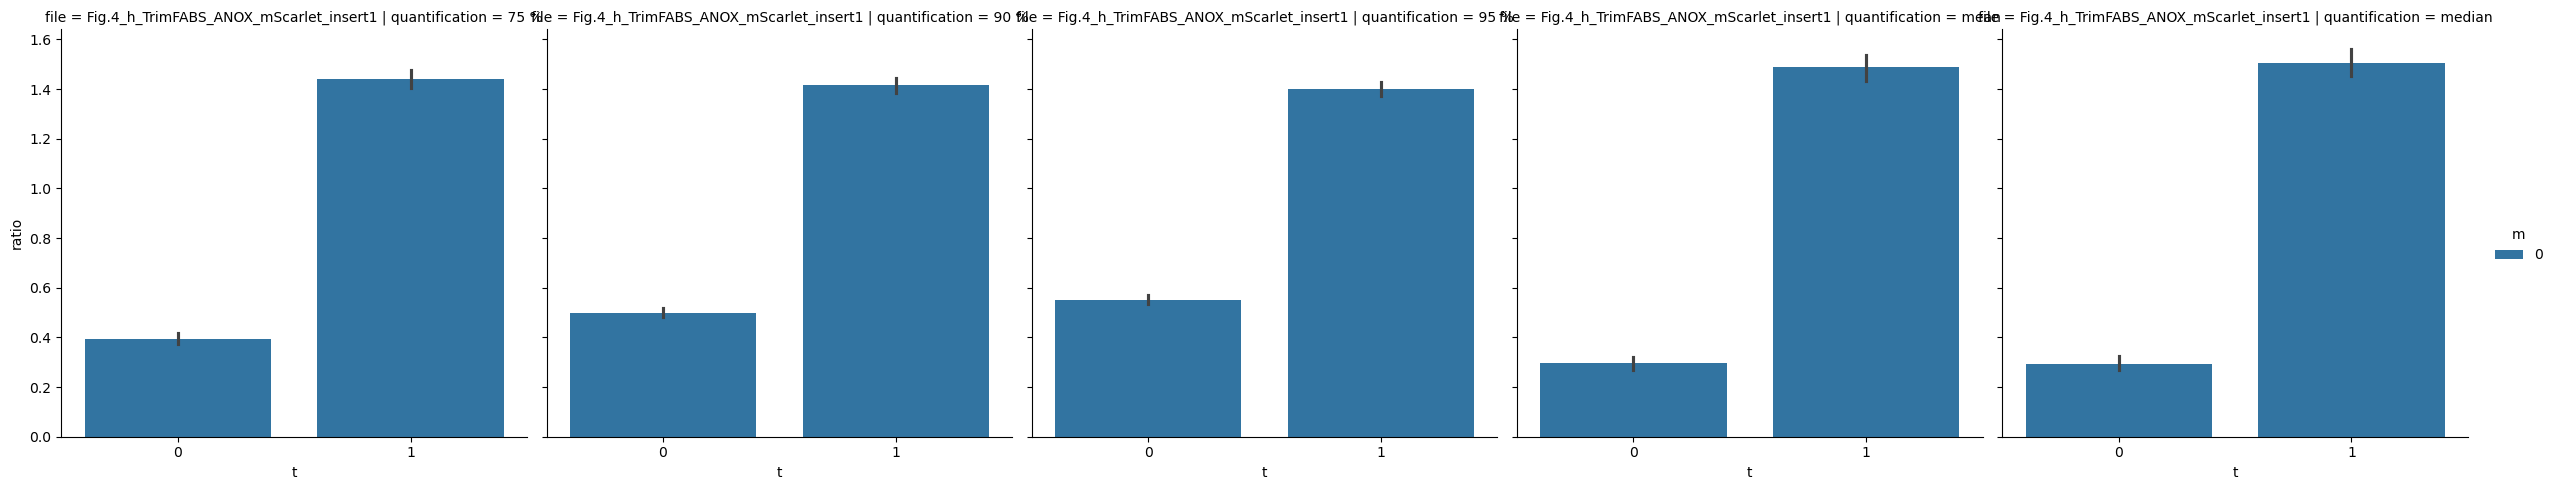

In [26]:
sns.catplot(
    data=df[df["aspect ratio"] > 2],
    x="t",
    y="ratio",
    hue="m",
    col="quantification",
    row="file",
    kind="bar",
)

In [ ]:
sns.catplot(
    data=df,
    x="t",
    y="ratio",
    hue="m",
    col="quantification",
    row="file",
    kind="box",
)

In [ ]:
sns.catplot(
    data=df,
    x="t",
    y="ratio",
    hue="m",
    col="quantification",
    row="file",
    kind="boxen",
)

In [ ]:
sns.catplot(
    data=df,
    x="t",
    y="ratio",
    col="quantification",
    kind="violin",
)

In [ ]:
sns.catplot(
    data=df,
    x="t",
    y="ratio",
    col="quantification",
    kind="bar",
)

In [ ]:
t = 1
m = 0
file = "Fig.4_h_TrimFABS_ANOX_mScarlet_insert1"
filename = f"{file}_t{t}_m{m}_mScarlet.tiff"

lbl = imread(os.path.join(root, "nfmp_prob0.6", model, filename))

In [ ]:
nd2_file = nd2.ND2File(os.path.join(root, file+".nd2"))
img = nd2_file.to_dask()[t, m, :, 1:].compute().transpose(0, 2, 3, 1)
nd2_file.close()

In [ ]:
img.shape

In [ ]:
objects = find_objects(lbl)

In [ ]:
def calc_ratios(values):
    means = np.concat((
        np.mean(values, axis=0)[np.newaxis, :],
        np.percentile(values, q=[50, 75, 90, 95], axis=0),
    ), axis=0)
    return means[:, 1] / means[:, 0]


values = []
for i, sl in enumerate(objects,1):
    if sl is None: continue
    mask = lbl[sl] == i
    values.append(calc_ratios(img[sl][mask]))
values = np.stack(values, axis=0)

In [ ]:
values.mean(axis=0), values.std(axis=0)

In [ ]:
values.mean(axis=0), values.std(axis=0)

In [ ]:
values